L'algorithme de Deutsch-Jozsa

L'agorithme de Deutsch-Jozsa est un algorithme déterministe proposé en 1992 par David Deutsch and Richard Jozsa.
Bien que peu utilisé, c'est un des premiers d'algorithme quantique exponentiellement plus rapide qu'un algortihme classique déterministe.

L'algorithme en quesiton permet de résoudre le problème portant le même nom. Ayant une boite noire quantique, connu sous le nom d'oracle qui implémente une fonciton mathématique :
    f : {0,1}^n --> {0,1}
Cette fonction a la particularité d'être soit constante soit équilibré (la sortie est à moitié 0 et à moitié 1).

Nous commençons par implémenter l'exemple de l'algorithme de Deutsch-Jozsa sur un example de fonction de 3 bits.

In [131]:
# initialization
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile, execute
from qiskit.tools.monitor import job_monitor

# import basic plot tools
from qiskit.visualization import plot_histogram

# import IBM Provider
from qiskit import IBMQ

Fixons tout d'abord la taille du registre input dans notre oracle.

In [132]:
# set the length of the n-bit input string. 
n = 3


4.1 Oracle constant

Commençons par créer notre oracle retournant des constantes. Tout d'abord dans notre cas, la sortie retournera des Qubits 0 ou 1 de manière aléatoire.
Par définition, un oracle constant ne doit pas avoir d'influencence sur l'entré. C'est à dire que l'état en entré doit être exactement le même à qu'à la sortie de l'oracle.

In [133]:
# set the length of the n-bit input string. 
n = 3

const_oracle = QuantumCircuit(n+1)

output = np.random.randint(2)
if output == 1:
    const_oracle.x(n)

const_oracle.draw()


q_0: 
     
q_1: 
     
q_2: 
     
q_3:

4.2 Oracle équilibré

Après l'étape de la porte d'Hadamard sur chaque Qubit, notre registre de donné possède une superposition d'état égale à tous les états dans la base. Lorsque l'oracle est équilibré, les phases permutent et la moitié états deviennet leur contraire.

In [134]:
balanced_oracle = QuantumCircuit(n+1)


Nous pouvons créer un oracle équilibré en jouant sur les portes CNOT selon laquel chaque qubits input seront joueront de controle et les bits outputs comme cible.
Nous pouvons faire varier les états d'entrés en switchant les Qubits à l'aide de porte NOT. La variable suivante permet de définir les Qubits à switcher.

In [135]:
b_str = "101"


Dans ce cas, une porte NOT sera placé sur le Qubit 0 et 2.

Nous pouvons modifier l'état du registre d'entré du Qubit n°1 sans que cela affect le comportement de notre oracle équilibré.

In [136]:
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)
balanced_oracle.draw()


┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘
q_3: ─────

Il existe plusieurs façon  de créer un oracle équilibré, l'une des méthodes utilisait est d'employé des opérateurs CNOT sur chaque Qubit du registre n°1 et de target le Qubit du registre n°2. 

Nous pouvons en déduire les tableaux à état suivant:

L'état de sortie vaut 0 lorsque le registre à l'entré est dans l'un de ces états

Output = 0|
----------|
000       |
011       |
101       |
110       |


L'état de sortie vaut 1 lorsque le registre à l'entré est dans l'un de ces états

Output = 1|
----------|
001       |
100       |
010       |
111       |

Une fois les états variés, nous pouvons utilisé les portes CNOT. 

Nous utilisons dans notre exemple la variable b_str comme clef secret.

Il est élément (décrit un peu plus tôt, f(x) dans |x⟩|y⊕f(x)⟩), que le circuit est sensé deviner 

In [137]:
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()
balanced_oracle.draw()


┌───┐ ░                 ░ 
q_0: ┤ X ├─░───■─────────────░─
     └───┘ ░   │             ░ 
q_1: ──────░───┼────■────────░─
     ┌───┐ ░   │    │        ░ 
q_2: ┤ X ├─░───┼────┼────■───░─
     └───┘ ░ ┌─┴─┐┌─┴─┐┌─┴─┐ ░ 
q_3: ──────░─┤ X ├┤ X ├┤ X ├─░─
           ░ └───┘└───┘└───┘ ░

Nous pouvons réappliquer une seconde fois la couche "envellopage"

In [138]:
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Show oracle
balanced_oracle.draw()


┌───┐ ░                 ░ ┌───┐
q_0: ┤ X ├─░───■─────────────░─┤ X ├
     └───┘ ░   │             ░ └───┘
q_1: ──────░───┼────■────────░──────
     ┌───┐ ░   │    │        ░ ┌───┐
q_2: ┤ X ├─░───┼────┼────■───░─┤ X ├
     └───┘ ░ ┌─┴─┐┌─┴─┐┌─┴─┐ ░ └───┘
q_3: ──────░─┤ X ├┤ X ├┤ X ├─░──────
           ░ └───┘└───┘└───┘ ░

Finalement, nous venons de créer notre oracle équilibré.
À ce niveau nous pouvons transformer |x⟩|y⟩ en |x⟩|y⊕f(x)⟩

Test de l'oracle par l'algorithme de Deutsch-Jozsa

Nous pouvons dorénavant compléter l'algorithme.
La première étape est d'initialiser les Qubits d'entrés dans l'état |+⟩ et les sortie dans l'état |-⟩

In [139]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)
dj_circuit.draw()


┌───┐     
q_0: ┤ H ├─────
     ├───┤     
q_1: ┤ H ├─────
     ├───┤     
q_2: ┤ H ├─────
     ├───┤┌───┐
q_3: ┤ X ├┤ H ├
     └───┘└───┘
c: 3/══════════

In [140]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle
dj_circuit += balanced_oracle
dj_circuit.draw()


┌───┐┌───┐ ░                 ░ ┌───┐
q_0: ┤ H ├┤ X ├─░───■─────────────░─┤ X ├
     ├───┤└───┘ ░   │             ░ └───┘
q_1: ┤ H ├──────░───┼────■────────░──────
     ├───┤┌───┐ ░   │    │        ░ ┌───┐
q_2: ┤ H ├┤ X ├─░───┼────┼────■───░─┤ X ├
     ├───┤├───┤ ░ ┌─┴─┐┌─┴─┐┌─┴─┐ ░ └───┘
q_3: ┤ X ├┤ H ├─░─┤ X ├┤ X ├┤ X ├─░──────
     └───┘└───┘ ░ └───┘└───┘└───┘ ░      
c: 3/════════════════════════════════════

Finallement, nous avons seulement appliqués des portes d'Hadamar

In [141]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle
dj_circuit += balanced_oracle

# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw()

┌───┐┌───┐ ░                 ░ ┌───┐┌───┐ ░ ┌─┐      
q_0: ┤ H ├┤ X ├─░───■─────────────░─┤ X ├┤ H ├─░─┤M├──────
     ├───┤└───┘ ░   │             ░ ├───┤└───┘ ░ └╥┘┌─┐   
q_1: ┤ H ├──────░───┼────■────────░─┤ H ├──────░──╫─┤M├───
     ├───┤┌───┐ ░   │    │        ░ ├───┤┌───┐ ░  ║ └╥┘┌─┐
q_2: ┤ H ├┤ X ├─░───┼────┼────■───░─┤ X ├┤ H ├─░──╫──╫─┤M├
     ├───┤├───┤ ░ ┌─┴─┐┌─┴─┐┌─┴─┐ ░ └───┘└───┘ ░  ║  ║ └╥┘
q_3: ┤ X ├┤ H ├─░─┤ X ├┤ X ├┤ X ├─░────────────░──╫──╫──╫─
     └───┘└───┘ ░ └───┘└───┘└───┘ ░            ░  ║  ║  ║ 
c: 3/═════════════════════════════════════════════╩══╩══╩═
                                                  0  1  2

Nous pouvons désormais mesurer les sorties

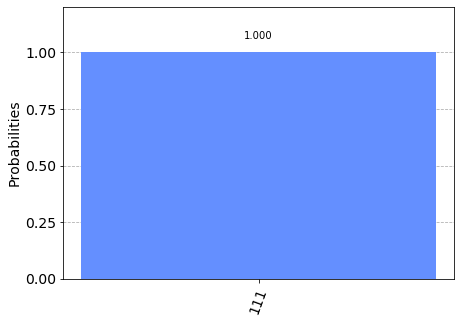

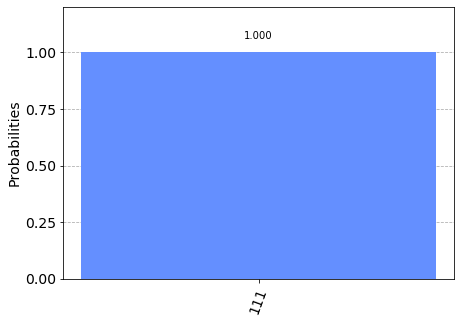

In [142]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(dj_circuit, aer_sim)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)


Nous pouvons voir sur le résultat qu'il y a 0% de chance de mesurer 000. Ce qui prédit correctement que la fonction est équilibré.

Circuit généralisé



In [143]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate


In [144]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit


In [145]:
n = 3
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw()


┌───┐     ┌─────────┐┌───┐┌─┐      
q_0: ┤ H ├─────┤0        ├┤ H ├┤M├──────
     ├───┤     │         │├───┤└╥┘┌─┐   
q_1: ┤ H ├─────┤1        ├┤ H ├─╫─┤M├───
     ├───┤     │  Oracle │├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├─────┤2        ├┤ H ├─╫──╫─┤M├
     ├───┤┌───┐│         │└───┘ ║  ║ └╥┘
q_3: ┤ X ├┤ H ├┤3        ├──────╫──╫──╫─
     └───┘└───┘└─────────┘      ║  ║  ║ 
c: 3/═══════════════════════════╩══╩══╩═
                                0  1  2

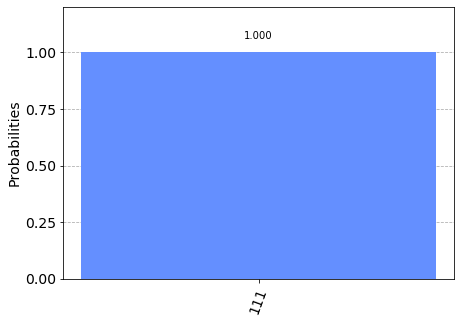

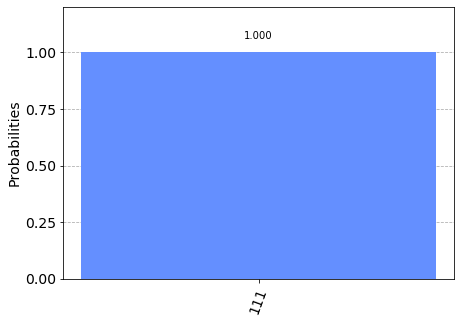

In [146]:
transpiled_dj_circuit = transpile(dj_circuit, aer_sim)
qobj = assemble(transpiled_dj_circuit)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)

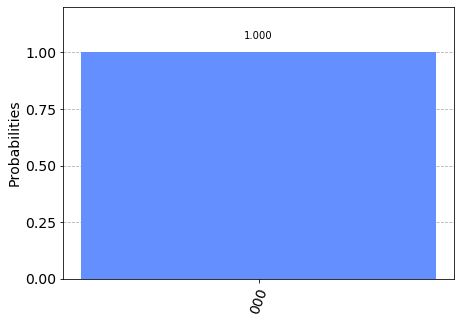

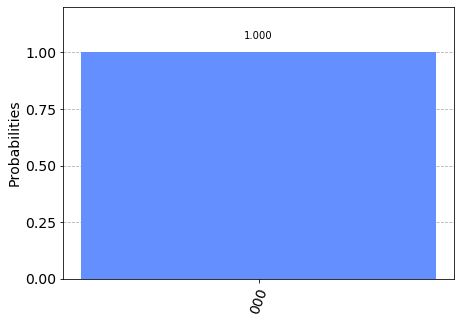

In [147]:
n = 3
oracle_gate = dj_oracle('constant', n)
dj_circuit = dj_algorithm(oracle_gate, n)
transpiled_dj_circuit = transpile(dj_circuit, aer_sim)
qobj = assemble(transpiled_dj_circuit)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)